In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-jobathon-sep2021/sample.csv
/kaggle/input/av-jobathon-sep2021/train.csv
/kaggle/input/av-jobathon-sep2021/test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns',500)
pd.set_option('display.width',500)
pd.set_option('display.max_rows', 500)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [5]:
df_train = pd.read_csv('/kaggle/input/av-jobathon-sep2021/train.csv')
df_train

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52
...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41


In [6]:
df_test = pd.read_csv('/kaggle/input/av-jobathon-sep2021/test.csv')
df_test

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No
...,...,...,...,...,...,...,...,...
22260,T1210601,186,S2,L5,R2,2019-07-31,0,No
22261,T1210602,11,S4,L2,R1,2019-07-31,0,No
22262,T1210603,185,S1,L1,R3,2019-07-31,0,Yes
22263,T1210604,69,S1,L1,R4,2019-07-31,0,No


In [7]:
def details(df):
    sum_null_values = df.isnull().sum()
    percent_null_values = 100* (sum_null_values/len(df))
    data_type = df.dtypes
    unique_values = df.nunique()

    table = pd.concat([sum_null_values,percent_null_values,data_type,unique_values], axis=1)
    table_col = table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Missing Values', 2 : 'Data_Type', 3: 'Unique values'})
    return table_col

In [8]:
details(df_train)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
ID,0,0.0,object,188340
Store_id,0,0.0,int64,365
Store_Type,0,0.0,object,4
Location_Type,0,0.0,object,5
Region_Code,0,0.0,object,4
Date,0,0.0,object,516
Holiday,0,0.0,int64,2
Discount,0,0.0,object,2
#Order,0,0.0,int64,299
Sales,0,0.0,float64,47422


In [9]:
details(df_test)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
ID,0,0.0,object,22265
Store_id,0,0.0,int64,365
Store_Type,0,0.0,object,4
Location_Type,0,0.0,object,5
Region_Code,0,0.0,object,4
Date,0,0.0,object,61
Holiday,0,0.0,int64,2
Discount,0,0.0,object,2


In [10]:
df_train["Date"]= pd.to_datetime(df_train["Date"])
df_test["Date"]= pd.to_datetime(df_test["Date"])

In [11]:
df_train['Store_Type'].value_counts()

S1    88752
S4    45924
S2    28896
S3    24768
Name: Store_Type, dtype: int64

In [12]:
df_train['Location_Type'].value_counts()

L1    85140
L2    48504
L3    29928
L5    13932
L4    10836
Name: Location_Type, dtype: int64

In [13]:
df_train['Region_Code'].value_counts()

R1    63984
R2    54180
R3    44376
R4    25800
Name: Region_Code, dtype: int64

In [14]:
df_train['Discount'].value_counts()

No     104051
Yes     84289
Name: Discount, dtype: int64

In [15]:
df_train['Holiday'].value_counts()

0    163520
1     24820
Name: Holiday, dtype: int64

In [16]:
df_train[['Store_id','#Order','Sales']].describe()

,Store_id,#Order,Sales
count,188340.000000,188340.000000,188340.000000
mean,183.000000,68.205692,42784.327982
std,105.366308,30.467415,18456.708302
min,1.000000,0.000000,0.000000
25%,92.000000,48.000000,30426.000000
50%,183.000000,63.000000,39678.000000
75%,274.000000,82.000000,51909.000000
max,365.000000,371.000000,247215.000000


In [17]:
train_data = df_train.copy()
test_data = df_test.copy()

In [18]:
train_data.Holiday = train_data.Holiday.map({0:'no',1:'yes'})
test_data.Holiday = test_data.Holiday.map({0:'no',1:'yes'})

In [19]:
cols_obj_train = train_data.select_dtypes('object').columns
train_data[cols_obj_train]

,ID,Store_Type,Location_Type,Region_Code,Holiday,Discount
0,T1000001,S1,L3,R1,yes,Yes
1,T1000002,S4,L2,R1,yes,Yes
2,T1000003,S3,L2,R1,yes,Yes
3,T1000004,S2,L3,R1,yes,Yes
4,T1000005,S2,L3,R4,yes,Yes
...,...,...,...,...,...,...
188335,T1188336,S2,L3,R2,yes,Yes
188336,T1188337,S4,L2,R1,yes,No
188337,T1188338,S1,L3,R2,yes,No
188338,T1188339,S3,L1,R2,yes,Yes


In [20]:
cols_num_train = train_data.select_dtypes('number').columns
train_data[cols_num_train]

,Store_id,#Order,Sales
0,1,9,7011.84
1,253,60,51789.12
2,252,42,36868.20
3,251,23,19715.16
4,250,62,45614.52
...,...,...,...
188335,149,51,37272.00
188336,153,90,54572.64
188337,154,56,31624.56
188338,155,70,49162.41


In [21]:
cols_obj_test = test_data.select_dtypes('object').columns
test_data[cols_obj_test]

,ID,Store_Type,Location_Type,Region_Code,Holiday,Discount
0,T1188341,S4,L2,R3,no,No
1,T1188342,S1,L1,R1,no,No
2,T1188343,S4,L2,R1,no,No
3,T1188344,S1,L1,R4,no,No
4,T1188345,S1,L1,R2,no,No
...,...,...,...,...,...,...
22260,T1210601,S2,L5,R2,no,No
22261,T1210602,S4,L2,R1,no,No
22262,T1210603,S1,L1,R3,no,Yes
22263,T1210604,S1,L1,R4,no,No


In [22]:
cols_num_test = test_data.select_dtypes('number').columns
test_data[cols_num_test]

,Store_id
0,171
1,172
2,173
3,174
4,170
...,...
22260,186
22261,11
22262,185
22263,69


In [23]:
details(train_data)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
ID,0,0.0,object,188340
Store_id,0,0.0,int64,365
Store_Type,0,0.0,object,4
Location_Type,0,0.0,object,5
Region_Code,0,0.0,object,4
Date,0,0.0,datetime64[ns],516
Holiday,0,0.0,object,2
Discount,0,0.0,object,2
#Order,0,0.0,int64,299
Sales,0,0.0,float64,47422


In [24]:
details(test_data)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
ID,0,0.0,object,22265
Store_id,0,0.0,int64,365
Store_Type,0,0.0,object,4
Location_Type,0,0.0,object,5
Region_Code,0,0.0,object,4
Date,0,0.0,datetime64[ns],61
Holiday,0,0.0,object,2
Discount,0,0.0,object,2


In [25]:
train_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,yes,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,yes,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,yes,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,yes,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,yes,Yes,62,45614.52
...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,yes,Yes,51,37272.00
188336,T1188337,153,S4,L2,R1,2019-05-31,yes,No,90,54572.64
188337,T1188338,154,S1,L3,R2,2019-05-31,yes,No,56,31624.56
188338,T1188339,155,S3,L1,R2,2019-05-31,yes,Yes,70,49162.41


In [26]:
ohe = OneHotEncoder(sparse=False)
ohe_df1 = pd.DataFrame(ohe.fit_transform(train_data[['Store_Type','Location_Type','Region_Code','Holiday','Discount']]),columns=ohe.get_feature_names())
ohe_df2 = pd.DataFrame(ohe.transform(test_data[['Store_Type','Location_Type','Region_Code','Holiday','Discount']]),columns=ohe.get_feature_names())

In [27]:
ohe_df1

,x0_S1,x0_S2,x0_S3,x0_S4,x1_L1,x1_L2,x1_L3,x1_L4,x1_L5,x2_R1,x2_R2,x2_R3,x2_R4,x3_no,x3_yes,x4_No,x4_Yes
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188335,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
188336,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
188337,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
188338,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [28]:
ohe_df2

,x0_S1,x0_S2,x0_S3,x0_S4,x1_L1,x1_L2,x1_L3,x1_L4,x1_L5,x2_R1,x2_R2,x2_R3,x2_R4,x3_no,x3_yes,x4_No,x4_Yes
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22260,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
22261,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
22262,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
22263,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [29]:
train_df = pd.concat([train_data, ohe_df1],1)
test_df = pd.concat([test_data, ohe_df2],1)

In [30]:
train_df

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,x0_S1,x0_S2,x0_S3,x0_S4,x1_L1,x1_L2,x1_L3,x1_L4,x1_L5,x2_R1,x2_R2,x2_R3,x2_R4,x3_no,x3_yes,x4_No,x4_Yes
0,T1000001,1,S1,L3,R1,2018-01-01,yes,Yes,9,7011.84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,T1000002,253,S4,L2,R1,2018-01-01,yes,Yes,60,51789.12,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,T1000003,252,S3,L2,R1,2018-01-01,yes,Yes,42,36868.20,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,T1000004,251,S2,L3,R1,2018-01-01,yes,Yes,23,19715.16,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,T1000005,250,S2,L3,R4,2018-01-01,yes,Yes,62,45614.52,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,yes,Yes,51,37272.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
188336,T1188337,153,S4,L2,R1,2019-05-31,yes,No,90,54572.64,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
188337,T1188338,154,S1,L3,R2,2019-05-31,yes,No,56,31624.56,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
188338,T1188339,155,S3,L1,R2,2019-05-31,yes,Yes,70,49162.41,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [31]:
test_df

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,x0_S1,x0_S2,x0_S3,x0_S4,x1_L1,x1_L2,x1_L3,x1_L4,x1_L5,x2_R1,x2_R2,x2_R3,x2_R4,x3_no,x3_yes,x4_No,x4_Yes
0,T1188341,171,S4,L2,R3,2019-06-01,no,No,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,T1188342,172,S1,L1,R1,2019-06-01,no,No,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,T1188343,173,S4,L2,R1,2019-06-01,no,No,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,T1188344,174,S1,L1,R4,2019-06-01,no,No,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,T1188345,170,S1,L1,R2,2019-06-01,no,No,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22260,T1210601,186,S2,L5,R2,2019-07-31,no,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
22261,T1210602,11,S4,L2,R1,2019-07-31,no,No,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
22262,T1210603,185,S1,L1,R3,2019-07-31,no,Yes,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
22263,T1210604,69,S1,L1,R4,2019-07-31,no,No,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


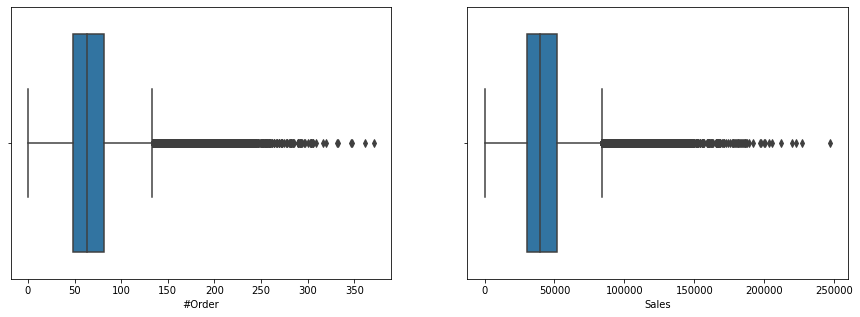

In [32]:
#Outliers
col_data = ['#Order','Sales']

plt.figure(figsize=(15,5))
for i in enumerate(col_data):
    plt.subplot(1,2,i[0]+1)
    sns.boxplot(train_df[i[1]])

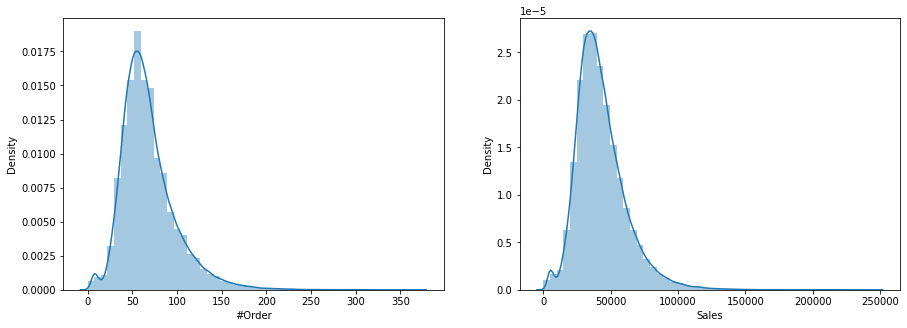

In [33]:
#Distribution
col_data = ['#Order','Sales']

plt.figure(figsize=(15,5))
for i in enumerate(col_data):
    plt.subplot(1,2,i[0]+1)
    sns.distplot(train_df[i[1]])

In [34]:
train_df.drop(['ID','Store_Type','Location_Type','Region_Code','Date','Holiday','Discount'],1, inplace=True)
test_df.drop(['ID','Store_Type','Location_Type','Region_Code','Date','Holiday','Discount'],1, inplace=True)

In [35]:
train_df

,Store_id,#Order,Sales,x0_S1,x0_S2,x0_S3,x0_S4,x1_L1,x1_L2,x1_L3,x1_L4,x1_L5,x2_R1,x2_R2,x2_R3,x2_R4,x3_no,x3_yes,x4_No,x4_Yes
0,1,9,7011.84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,253,60,51789.12,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,252,42,36868.20,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,251,23,19715.16,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,250,62,45614.52,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188335,149,51,37272.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
188336,153,90,54572.64,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
188337,154,56,31624.56,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
188338,155,70,49162.41,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [36]:
# Power_transformer
# pt = PowerTransformer(copy=False)
# train_df[['#Order']] = pt.fit_transform(train_df[['#Order']])
# train_df[['Sales']] = pt.fit_transform(train_df[['Sales']])
# pt.transform(test_df)

In [37]:
# train_df

In [38]:
# col_data = ['#Order','Sales']

# plt.figure(figsize=(15,5))
# for i in enumerate(col_data):
#     plt.subplot(1,2,i[0]+1)
#     sns.distplot(train_df[i[1]])

In [39]:
#Splitting
X = train_df.drop(['Sales'],1)
y = train_df['Sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=23)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((131838, 19), (56502, 19), (131838,), (56502,))

In [40]:
# lr = LinearRegression()
# lr.fit(X_train,y_train)
# y_pred_train = lr.predict(X_train)
# y_val_pred = lr.predict(X_val)
# msle_lr = mean_squared_log_error(y_val, y_val_pred)
# msle_lr

In [41]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
y_pred_train = dt.predict(X_train)
y_val_pred = dt.predict(X_val)
msle_dt = mean_squared_log_error(y_val, y_val_pred)
1000*msle_dt

11.221429842744481

In [42]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred_train = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
msle_rf = mean_squared_log_error(y_val, y_val_pred)
1000*msle_rf

9.47810434951487

In [43]:
X = X.drop('#Order',1)

In [44]:
rf.fit(X,y)
y_pred_train = rf.predict(X)
y_test_pred = rf.predict(test_df)

In [45]:
submission = pd.DataFrame({'ID': test_data['ID'], 'Sales': y_test_pred})
submission.shape

(22265, 2)

In [46]:
submission.to_csv(r'C:\Users\getch\Documents\notebook\submission.csv', index = False)
submission

,ID,Sales
0,T1188341,48601.124077
1,T1188342,35853.258389
2,T1188343,70485.249399
3,T1188344,33016.922656
4,T1188345,36112.895245
...,...,...
22260,T1210601,19943.036246
22261,T1210602,57019.438353
22262,T1210603,48753.079101
22263,T1210604,31887.274733
